In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.tree import export_graphviz
import pydot

In [2]:
def compute_metrics(y_true,y_pred):
    accuracy = accuracy_score(y_true,y_pred)
    f1_score_1 = f1_score(y_true,y_pred,average='binary',pos_label=1)
    f1_score_0 = f1_score(y_true,y_pred,average='binary',pos_label=0)
    f1_score_macro = f1_score(y_true,y_pred,average='macro')
    return [accuracy,f1_score_1,f1_score_0,f1_score_macro]

results = pd.DataFrame(columns=['Accuracy', 'F1-score (class 1)', 'F1-score (class 0)', 'F1-score (macro avg)'])

# Random Forrest on regualr season vs playoff

In [3]:
train = pd.read_csv('../data/data3_train.csv')
test = pd.read_csv('../data/data3_test.csv')
target_column = "shot_made_flag"  # y_column_name

In [4]:
def split_x_y(df, target):
    y = df.loc[:, [target]]
    x = df.drop([target], axis=1)
    return x, y

In [5]:
x_train, y_train = split_x_y(train, target_column)
x_test, y_test = split_x_y(test, target_column)

We are using out of the bag score (oob_score) as a way to validate our model.
Instead of using validation set and introducing data leakage, with the oob_score we are estimating the validation score.
# VERIFY

In [6]:
model_rf1 = RandomForestClassifier(oob_score=True).fit(x_train, y_train)

/tmp/ipykernel_117224/4285322127.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf1 = RandomForestClassifier(oob_score=True).fit(x_train, y_train)


In [7]:
pred = model_rf1.predict(x_train)

Performing a sanity check

In [8]:
confusion_matrix(y_train,pred)

array([[734,   0],
       [  0, 610]])

In [9]:
print('OOB accuracy=', model_rf1.oob_score_)

OOB accuracy= 0.6830357142857143


In [10]:
y_pred = model_rf1.predict(x_test)

In [11]:
confusion_matrix(y_test,y_pred)

array([[198,  36],
       [112,  82]])

In [12]:
results.loc['RF-basic', :] = compute_metrics(y_test, y_pred)
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-basic,0.654206,0.525641,0.727941,0.626791


# are the reults ok? not overfitted?

# try balanced

In [13]:
model_rf2 = RandomForestClassifier(n_estimators=100,
                                   oob_score=True,
                                   class_weight='balanced').fit(x_train, y_train)

/tmp/ipykernel_117224/215878088.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf2 = RandomForestClassifier(n_estimators=100,


In [14]:
print('OOB accuracy=', model_rf2.oob_score_)

OOB accuracy= 0.6927083333333334


In [15]:
y_pred = model_rf2.predict(x_test)

In [16]:
results.loc['RF-balanced', :] = compute_metrics(y_test, y_pred)
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-balanced,0.675234,0.538206,0.74955,0.643878
RF-basic,0.654206,0.525641,0.727941,0.626791


# Check the tree that we generated

In [17]:
x_train

,loc_x,loc_y,period,playoffs,shot_distance,shot_zone_basic,shot_zone_range,time_remaining,last_5_games_avg,streak_before_shot,...,shot_type_2PT Field Goal,shot_type_3PT Field Goal,shot_zone_area_Back Court(BC),shot_zone_area_Center(C),shot_zone_area_Left Side Center(LC),shot_zone_area_Left Side(L),shot_zone_area_Right Side Center(RC),shot_zone_area_Right Side(R),matchup_away,matchup_home
0,0,0,1,0,0,0,0,660,0.00,0,...,1,0,0,1,0,0,0,0,0,1
1,0,0,4,0,0,0,0,113,0.00,0,...,1,0,0,1,0,0,0,0,0,1
2,143,28,4,0,14,2,1,216,0.00,0,...,1,0,0,0,0,0,0,1,0,1
3,-56,279,4,0,28,4,3,339,0.00,0,...,0,1,0,1,0,0,0,0,0,1
4,34,82,4,0,8,1,1,596,0.00,0,...,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,0,0,1,0,0,0,0,386,0.43,0,...,1,0,0,1,0,0,0,0,0,1
1340,-109,110,1,0,15,2,1,641,0.43,0,...,1,0,0,0,0,1,0,0,0,1
1341,-87,290,4,0,30,4,3,49,0.43,0,...,0,1,0,1,0,0,0,0,0,1
1342,70,132,3,0,14,1,1,622,0.43,0,...,1,0,0,1,0,0,0,0,0,1


In [18]:
# Import tools needed for visualization

# Pull out one tree from the forest
def visualize_rf_tree(model):
    tree = model.estimators_[0]# Import tools needed for visualization
    tree = model.estimators_[0]# Export the image to a dot file
    export_graphviz(tree, out_file = 'tree.dot', feature_names = list(x_train.columns), rounded = True, precision = 1)# Use dot file to create a graph
    (graph, ) = pydot.graph_from_dot_file('tree.dot')# Write graph to a png file
    graph.write_png('tree.png')

In [19]:
visualize_rf_tree(model_rf1)

# depth3

In [20]:
model_rf3_small = RandomForestClassifier(max_depth=3, n_estimators=10)
model_rf3_small.fit(x_train, y_train)

/tmp/ipykernel_117224/3649734110.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf3_small.fit(x_train, y_train)


RandomForestClassifier(max_depth=3, n_estimators=10)

In [21]:
y_pred = model_rf3_small.predict(x_test)

results.loc['RF-small', :] = compute_metrics(y_test, y_pred)
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-small,0.67757,0.543046,0.750903,0.646974
RF-balanced,0.675234,0.538206,0.74955,0.643878
RF-basic,0.654206,0.525641,0.727941,0.626791


# GridSearch
## What do we do with CV?

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


model = RandomForestClassifier()

ntrees = [10, 100, 200,None]
max_depth = [5, 10, 50, 100, None]
min_samples_split = [4,6]
min_samples_leaf = [4,6]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=model,
                   # scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth':max_depth,
                       'min_samples_split':min_samples_split,
                       'min_samples_leaf':min_samples_leaf,
                       'class_weight':balance
                   },
                   cv=None,
                   return_train_score=False,
                   refit=False,
                   n_jobs=-1)

trc.fit(x_train, y_train)

/home/filip/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/filip/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/filip/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/filip/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed whe

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced',
                                          'balanced_subsample'],
                         'max_depth': [5, 10, 50, 100, None],
                         'min_samples_leaf': [4, 6],
                         'min_samples_split': [4, 6],
                         'n_estimators': [10, 100, 200, None]},
             refit=False)

In [29]:
trc.best_params_

{'class_weight': None,
 'max_depth': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 6,
 'n_estimators': 100}

In [30]:
model_rf4_gs = RandomForestClassifier(**trc.best_params_)


In [31]:
model_rf4_gs.fit(x_train, y_train)

/tmp/ipykernel_117224/2237850149.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf4_gs.fit(x_train, y_train)


RandomForestClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=6)

In [32]:
y_pred = model_rf4_gs.predict(x_test)
results.loc['RF-gridsearch', :] = compute_metrics(y_test, y_pred)
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-small,0.67757,0.543046,0.750903,0.646974
RF-balanced,0.675234,0.538206,0.74955,0.643878
RF-gridsearch,0.67757,0.530612,0.754448,0.64253
RF-basic,0.654206,0.525641,0.727941,0.626791


In [33]:
confusion_matrix(y_test, y_pred)

array([[212,  22],
       [116,  78]])

# Check feature importance

In [81]:
model_rf4_gs.feature_importances_

array([0.03742408, 0.04527659, 0.01375766, 0.        , 0.04126694,
       0.01641891, 0.01536579, 0.04790104, 0.02941525, 0.01475075,
       0.02656914, 0.03706889, 0.01836597, 0.01934253, 0.39288273,
       0.09915376, 0.02082521, 0.0391869 , 0.00124364, 0.0314065 ,
       0.00570468, 0.0004008 , 0.00306932, 0.00789498, 0.        ,
       0.01046277, 0.00270984, 0.00386227, 0.00185871, 0.00082232,
       0.00870737, 0.00688466])

In [82]:
# Get numerical feature importances
importances = list(model_rf4_gs.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(x_train.columns), importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: action_type_te       Importance: 0.39
Variable: opponent_te          Importance: 0.1
Variable: loc_y                Importance: 0.05
Variable: time_remaining       Importance: 0.05
Variable: loc_x                Importance: 0.04
Variable: shot_distance        Importance: 0.04
Variable: fgp_before_shot      Importance: 0.04
Variable: combined_shot_type_Dunk Importance: 0.04
Variable: last_5_games_avg     Importance: 0.03
Variable: points_before_shot   Importance: 0.03
Variable: combined_shot_type_Jump Shot Importance: 0.03
Variable: shot_zone_basic      Importance: 0.02
Variable: shot_zone_range      Importance: 0.02
Variable: month                Importance: 0.02
Variable: weekday              Importance: 0.02
Variable: combined_shot_type_Bank Shot Importance: 0.02
Variable: period               Importance: 0.01
Variable: streak_before_shot   Importance: 0.01
Variable: combined_shot_type_Layup Importance: 0.01
Variable: shot_type_3PT Field Goal Importance: 0.01
Variable: shot

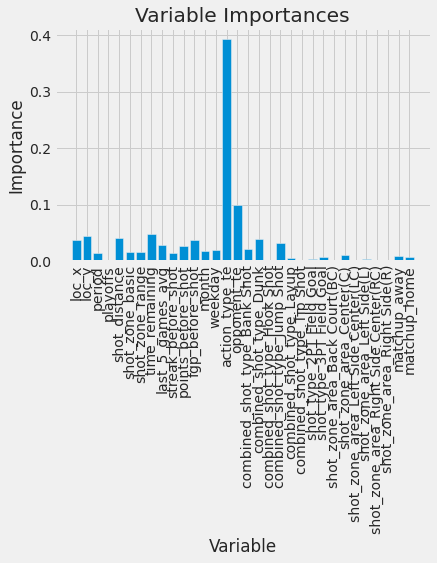

In [83]:
# Set the style
plt.style.use('fivethirtyeight')# list of x locations for plotting
x_values = list(range(len(importances)))# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')# Tick labels for x axis
plt.xticks(x_values, list(x_train.columns), rotation='vertical')# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# Run with reduced features

In [84]:
top_features = [tuple[0] for tuple in feature_importances[:5]]

In [85]:
top_features

['action_type_te', 'opponent_te', 'loc_y', 'time_remaining', 'loc_x']

In [86]:
x_train_top = x_train.loc[:, top_features]
x_test_top = x_test.loc[:, top_features]

In [87]:
x_test_top

,action_type_te,opponent_te,loc_y,time_remaining,loc_x
0,0.736842,0.387755,0,443,0
1,0.342105,0.387755,118,194,-112
2,0.777778,0.387755,34,242,-62
3,0.000000,0.387755,0,277,0
4,0.342105,0.387755,42,391,233
...,...,...,...,...,...
423,0.392857,0.416667,0,488,0
424,0.342105,0.416667,162,498,-73
425,0.342105,0.416667,157,237,111
426,1.000000,0.416667,151,154,20


In [88]:
model_rf5_top = RandomForestClassifier(**trc.best_params_)

In [89]:
model_rf5_top.fit(x_train_top, y_train)

/tmp/ipykernel_117224/4164285385.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf5_top.fit(x_train_top, y_train)


RandomForestClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=6)

In [90]:
y_pred = model_rf5_top.predict(x_test_top)

In [91]:
y_pred = model_rf4_gs.predict(x_test)
results.loc['RF-gridsearch-top', :] = compute_metrics(y_test, y_pred)
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-small,0.67757,0.543046,0.750903,0.646974
RF-balanced,0.675234,0.538206,0.74955,0.643878
RF-gridsearch,0.67757,0.530612,0.754448,0.64253
RF-gridsearch-top,0.67757,0.530612,0.754448,0.64253
RF-basic,0.654206,0.525641,0.727941,0.626791
